# 公共数据

In [1]:
import pandas as pd

In [2]:
df1 = pd.read_excel('dataset/附件一：已结束项目任务数据.xls')
task_location_values = df1[['任务gps经度','任务gps 纬度']].values
task_price_values = df1['任务标价'].values

In [3]:
df2 = pd.read_excel('dataset/附件二：会员信息数据-分列.xlsx')
vip_location_values = df2[['会员位置经度','会员位置纬度']].values
vip_lim_values = df2['预订任务限额'].values
vip_credit_values = df2['信誉值'].values

In [4]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']   #解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False    # 解决中文显示问题

In [5]:
import numpy as np
def get_euclidean_dis(x1, y1, x2, y2):
    x_squ = (x1 - x2)**2
    y_squ = (y1 - y2)**2
    dis = np.sqrt(x_squ + y_squ) * 111 * 1000
    return dis

## 计算得到的数据

### 与城市中心的距离

In [6]:
from sklearn.cluster import KMeans
import numpy as np
cluster = KMeans(n_clusters=4,random_state=0).fit(task_location_values)
y_pred = cluster.labels_
centroid = cluster.cluster_centers_
task_dis_to_city_center = np.zeros(len(df1))
for i in range(len(task_location_values)):
    center_loc = centroid[y_pred[i]]
    task_dis_to_city_center[i] = get_euclidean_dis(task_location_values[i,0],
                                                   task_location_values[i,1],
                                                   center_loc[0],
                                                   center_loc[1])
pd.DataFrame(task_dis_to_city_center).describe()

D:\ProgramData\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


,0
count,835.000000
mean,17783.392481
std,9654.577805
min,396.992079
25%,11623.089207
50%,16396.632905
75%,22787.597732
max,94366.816502


### 附近任务数

In [7]:
import numpy as np
task_num = len(df1)
task_around_task_count = np.zeros(task_num)
for i in range(task_num):
    for j in range(task_num):
        if i == j:
            continue
        if get_euclidean_dis(task_location_values[i,0],task_location_values[i,1],
                             task_location_values[j,0],task_location_values[j,1],)<=2000:
            task_around_task_count[i] += 1

### 附近会员数及平均完成能力

In [8]:
def entropy_weight(data):
    # 假设data已经正向化过了
    data = np.array(data)
    # 归一化（可能已经归约过了）
    data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))
    # 概率矩阵
    p = data / data.sum(axis=0)
    # 信息熵
    E = - np.nansum(p * np.log(np.where(p==0,1,p)), axis=0) / np.log(len(data[0]))
    # 熵权
    return (1 - E) / (1 - E).sum()

In [9]:
vip_lim_credit = np.hstack((vip_lim_values.reshape(-1,1),vip_credit_values.reshape(-1,1)))
vip_cap_w = entropy_weight(vip_lim_credit)
print(vip_cap_w)
vip_lim_credit_con = (vip_lim_credit - vip_lim_credit.min(axis=0)) / (vip_lim_credit.max(axis=0) - vip_lim_credit.min(axis=0))
vip_capbility = (vip_cap_w * vip_lim_credit_con).sum(axis=1)
print(vip_lim_credit_con)
print(vip_capbility)

[0.61346148 0.38653852]
[[4.89177489e-01 1.00000000e+00]
 [7.01298701e-01 5.57764693e-01]
 [5.97402597e-01 4.11089860e-01]
 ...
 [0.00000000e+00 8.97093300e-08]
 [0.00000000e+00 5.14725664e-08]
 [0.00000000e+00 0.00000000e+00]]
[6.86630069e-01 6.45817277e-01 5.25385547e-01 ... 3.46761120e-08
 1.98961298e-08 0.00000000e+00]


In [10]:
import numpy as np
task_num = len(df1)
vip_num = len(df2)
task_around_vip_count = np.zeros(task_num)
task_around_vip_capbility_sum = np.zeros(task_num)
for i in range(task_num):
    for j in range(vip_num):
        if get_euclidean_dis(task_location_values[i,0],task_location_values[i,1],
                             vip_location_values[j,0],vip_location_values[j,1]) <= 2000:
            task_around_vip_count[i] += 1
            task_around_vip_capbility_sum[i] += vip_capbility[i]
task_around_vip_capbility_ave = task_around_vip_capbility_sum / np.where(task_around_vip_count==0,
                                                              1,task_around_vip_count)

# 问题3

## 任务打包

### 层次聚类

In [11]:
import numpy as np
def compute_agg_dis(X):
    X_num = X.shape[0]
    dis_mat = np.zeros((X_num, X_num))
    task_dis_to_city_center_median = np.median(task_dis_to_city_center)
    task_around_vip_count_median = np.median(task_around_vip_count)
    task_around_vip_capbility_ave_median = np.median(task_around_vip_capbility_ave)
    for i in range(X_num):
        for j in range(X_num):
            if i == j:
                continue
            coef_i = 1
            coef_j = 1
            if task_dis_to_city_center[i]<task_dis_to_city_center_median:
                coef_i *= 0.7
            if task_around_vip_count[i]<task_around_vip_count_median:
                coef_i *= 0.7
            if task_around_vip_capbility_ave[i]<task_around_vip_capbility_ave_median:
                coef_i *= 0.7
            if task_dis_to_city_center[j]<task_dis_to_city_center_median:
                coef_j *= 0.7
            if task_around_vip_count[j]<task_around_vip_count_median:
                coef_j *= 0.7
            if task_around_vip_capbility_ave[j]<task_around_vip_capbility_ave_median:
                coef_j *= 0.7
            dis_mat[i,j] = get_euclidean_dis(X[i,0],X[i,1],X[j,0],X[j,1]) * coef_i * coef_j
    return dis_mat

In [12]:
from sklearn.cluster import AgglomerativeClustering
X = np.array((task_location_values[:,0],
             task_location_values[:,1],
             task_dis_to_city_center,
             task_around_vip_count,
             task_around_vip_capbility_ave)).T
model = AgglomerativeClustering(distance_threshold=2000, 
                                affinity=compute_agg_dis,
                                linkage="complete", 
                                n_clusters=None,
                               compute_full_tree=True)
model.fit(X)
n_clusters = len(pd.Series(model.labels_).unique())
X = task_location_values
len(pd.Series(model.labels_).unique())

199

### 调整聚类结果/二次聚类

In [14]:
cluster_task_counts = pd.DataFrame(model.labels_).value_counts()
cluster_task_to_divide_se = cluster_task_counts[cluster_task_counts > 6]
new_label_number = len(pd.Series(model.labels_).unique())
new_labels_ = np.array(model.labels_)
for idx in cluster_task_to_divide_se.index:
    X_cluster = X[model.labels_ == idx]
    count_before = cluster_task_to_divide_se.loc[idx]
    n_clusters = np.ceil(count_before / 3).astype('int')
    new_model = AgglomerativeClustering(n_clusters=n_clusters,affinity=compute_agg_dis,linkage="complete").fit(X_cluster)
    new_labels_[model.labels_ == idx] = new_model.labels_ + new_label_number
    new_label_number += new_model.labels_.max()+1
pd.DataFrame(new_labels_).value_counts().sort_values(ascending=False)

232    7
104    6
0      6
21     6
283    6
      ..
151    1
211    1
150    1
215    1
360    1
Length: 314, dtype: int64

232    7
104    6
0      6
21     6
283    6
      ..
151    1
211    1
150    1
215    1
360    1
Length: 314, dtype: int64

### 可视化

In [15]:
color = ['aliceblue',
'antiquewhite',
'aqua',
'aquamarine',
'azure',
'beige',
'bisque',
'black',
'blanchedalmond',
'blue',
'blueviolet',
'brown',
'burlywood',
'cadetblue',
'chartreuse',
'chocolate',
'coral',
'cornflowerblue',
'cornsilk',
'crimson',
'cyan',
'darkblue',
'darkcyan',
'darkgoldenrod',
'darkgray',
'darkgreen',
'darkgrey',
'darkkhaki',
'darkmagenta',
'darkolivegreen',
'darkorange',
'darkorchid',
'darkred',
'darksalmon',
'darkseagreen',
'darkslateblue',
'darkslategray',
'darkslategrey',
'darkturquoise',
'darkviolet',
'deeppink',
'deepskyblue',
'dimgray',
'dimgrey',
'dodgerblue',
'firebrick',
'floralwhite',
'forestgreen',
'fuchsia',
'gainsboro',
'ghostwhite',
'gold',
'goldenrod',
'gray',
'green',
'greenyellow',
'grey',
'honeydew',
'hotpink',
'indianred',
'indigo',
'ivory',
'khaki',
'lavender',
'lavenderblush',
'lawngreen',
'lemonchiffon',
'lightblue',
'lightcoral',
'lightcyan',
'lightgoldenrodyellow',
'lightgray',
'lightgreen',
'lightgrey',
'lightpink',
'lightsalmon',
'lightseagreen',
'lightskyblue',
'lightslategray',
'lightslategrey',
'lightsteelblue',
'lightyellow',
'lime',
'limegreen',
'linen',
'magenta',
'maroon',
'mediumaquamarine',
'mediumblue',
'mediumorchid',
'mediumpurple',
'mediumseagreen',
'mediumslateblue',
'mediumspringgreen',
'mediumturquoise',
'mediumvioletred',
'midnightblue',
'mintcream',
'mistyrose',
'moccasin',
'navajowhite',
'navy',
'oldlace',
'olive',
'olivedrab',
'orange',
'orangered',
'orchid',
'palegoldenrod',
'palegreen',
'paleturquoise',
'palevioletred',
'papayawhip',
'peachpuff',
'peru',
'pink',
'plum',
'powderblue',
'purple',
'rebeccapurple',
'red',
'rosybrown',
'royalblue',
'saddlebrown',
'salmon',
'sandybrown',
'seagreen',
'seashell',
'sienna',
'silver',
'skyblue',
'slateblue',
'slategray',
'slategrey',
'snow',
'springgreen',
'steelblue',
'tan',
'teal',
'thistle',
'tomato',
'turquoise',
'violet',
'wheat',
'white',
'whitesmoke',
'yellow',
'yellowgreen']

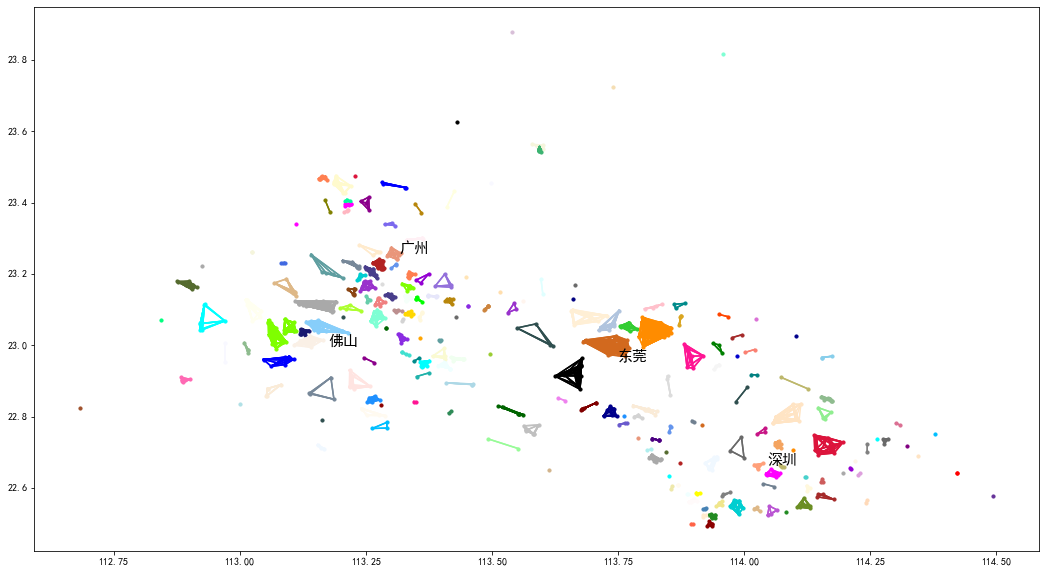

In [16]:
fig, ax1 = plt.subplots(1)
for i in range(len(model.labels_)):
    ax1.scatter(X[model.labels_==i, 0], X[model.labels_==i, 1]
            ,marker='o' #点的形状
            ,s=10 #点的大小
            ,c=color[np.mod(i,len(color))]
           )
    point_count = len(X[model.labels_==i])
    for j in range(point_count):
        for k in range(point_count):
            if i == k:
                continue
            ax1.plot(X[model.labels_==i][[j,k],[0,0]],X[model.labels_==i][[j,k],[1,1]],c=color[np.mod(i,len(color))])
#     center = X[y_pred==i].sum(axis=0)/(y_pred==i).sum()
#     ax1.scatter(center[0], center[1]
#             ,marker='*' #点的形状
#             ,s=100 #点的大小
#             ,c=color[np.mod(i,len(color))]
#            )
ax1.text(centroid[0,0], centroid[0,1], '广州', fontsize=15)
ax1.text(centroid[1,0], centroid[1,1], '深圳', fontsize=15)
ax1.text(centroid[2,0], centroid[2,1], '东莞', fontsize=15)
ax1.text(centroid[3,0], centroid[3,1], '佛山', fontsize=15)
fig.set_size_inches(18, 10)
plt.show()

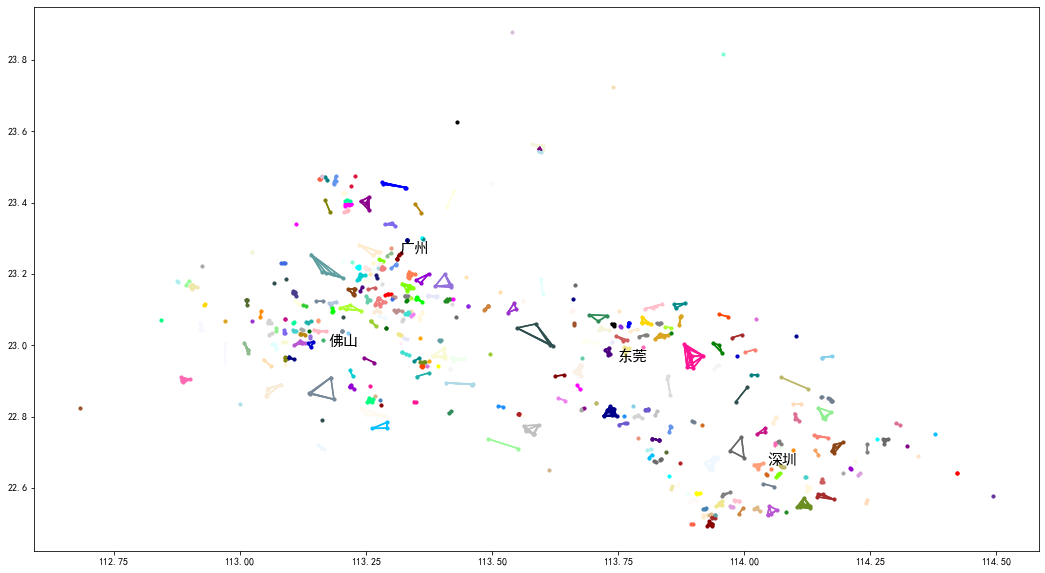

In [17]:
fig, ax1 = plt.subplots(1)
for i in range(len(new_labels_)):
    ax1.scatter(X[new_labels_==i, 0], X[new_labels_==i, 1]
            ,marker='o' #点的形状
            ,s=10 #点的大小
            ,c=color[np.mod(i,len(color))]
           )
    point_count = len(X[new_labels_==i])
    for j in range(point_count):
        for k in range(point_count):
            if i == k:
                continue
            ax1.plot(X[new_labels_==i][[j,k],[0,0]],X[new_labels_==i][[j,k],[1,1]],c=color[np.mod(i,len(color))])
#     center = X[y_pred==i].sum(axis=0)/(y_pred==i).sum()
#     ax1.scatter(center[0], center[1]
#             ,marker='*' #点的形状
#             ,s=100 #点的大小
#             ,c=color[np.mod(i,len(color))]
#            )
ax1.text(centroid[0,0], centroid[0,1], '广州', fontsize=15)
ax1.text(centroid[1,0], centroid[1,1], '深圳', fontsize=15)
ax1.text(centroid[2,0], centroid[2,1], '东莞', fontsize=15)
ax1.text(centroid[3,0], centroid[3,1], '佛山', fontsize=15)
fig.set_size_inches(18, 10)
plt.show()

## 重新定价并分析效果

### 生成任务包表格

In [115]:
task_pack_num = len(pd.Series(new_labels_).unique())
task_num = len(new_labels_)
visited = np.array([False]*task_num)
tasks_idx_arr = np.zeros(task_pack_num,dtype=object)
j = 0
for i in range(task_num):
    if (visited[i]): 
        continue
    visited[i] = True
    task_pack_choosed = new_labels_ == new_labels_[i]
    visited[task_pack_choosed] = True
    tasks_idx_arr[j] = np.array(range(task_num))[task_pack_choosed]
    j += 1
task_pack_number_df = pd.DataFrame({'task_pack_idx':range(task_pack_num), 'tasks_idx':tasks_idx_arr})
task_pack_number_df

,task_pack_idx,tasks_idx
0,0,"[0, 28, 361, 443]"
1,1,"[1, 75, 101, 106, 363, 445]"
2,2,"[2, 357, 359]"
3,3,"[3, 5]"
4,4,"[4, 7, 27, 32]"
...,...,...
309,309,"[810, 811, 812, 818]"
310,310,"[815, 816, 822]"
311,311,[820]
312,312,[825]


### 修改模型

In [126]:
import numpy as np
import pandas as pd

class FixPrice:
    df1 = None       # 表一
    df2 = None       # 表二
    a = 0            # 系数
    b = 0            # 系数
    X1 = None        # 任务坐标
    X2 = None        # 会员坐标
    w_limit = None   # 任务吸引度阈值
    w_packed = None         # 打包后的任务对会员的吸引度
    X1_packed = None # 打包后的任务坐标
    w_limit_packed = None # 打包后的阈值
    
    def __init__(self, a = 0.01175, b = 0.000164):
        df1 = pd.read_excel('dataset/2017B/附件一：已结束项目任务数据.xls')
        df2 = pd.read_excel('dataset/2017B/附件二：会员信息数据-分列.xlsx')
        self.df1 = df1
        self.df2 =df2
        self.a = a
        self.b = b
        
        C_before = np.array(df1['任务执行情况'])
        P_before = np.array(df1['任务标价'])
        
        X1 = np.array(df1[['任务gps 纬度','任务gps经度']])
        X2 = np.array(df2[['会员位置纬度','会员位置经度']])
        
        self.X1 = X1
        self.X2 = X2
        
        # 计算阈值
        w_before = np.zeros((X1.shape[0],X2.shape[0]))
        for i in range(X1.shape[0]):
            for j in range(X2.shape[0]):
                l = ((X1[i,0] - X2[j,0])**2 + (X1[i,1] - X2[j,1])**2)*111**2
                w_before[i,j] = np.sqrt(a/l + b * P_before[i]**2)
        self.w_limit = np.zeros(X1.shape[0])
        for i in range(X1.shape[0]):
            if C_before[i] == 1:
                self.w_limit[i] = np.min(w_before[i])
            else:
                self.w_limit[i] = np.max(w_before[i])
        # 计算打包后任务的各项指标
        task_pack_num = len(task_pack_number_df)
        self.X1_packed = np.zeros((task_pack_num,2))
        self.w_limit_packed = np.zeros(task_pack_num)
        for i in range(task_pack_num):
            tasks_to_pack = task_pack_number_df.iloc[i]['tasks_idx']
            self.X1_packed[i][0] = self.X1[tasks_to_pack,0].mean()
            self.X1_packed[i][1] = self.X1[tasks_to_pack,1].mean()
            self.w_limit_packed[i] = self.w_limit[tasks_to_pack].sum()
#         print(self.X1_packed)
        print(self.w_limit_packed)
        
        
                
    def makePrice(self,P):     # 根据定价求吸引度
        # 计算吸引度,距离单位为km
        self.w_packed = np.zeros((self.X1_packed.shape[0],self.X2.shape[0]))
        for i in range(self.X1_packed.shape[0]):
            for j in range(self.X2.shape[0]):
                tasks_idx = task_pack_number_df['tasks_idx'][i]
                task_count = len(tasks_idx)
                task_dis_sum = 0
                task_dis_ave = 0
                if task_count != 1:
                    for each_task_one in range(task_count):
                        for each_task_two in range(task_count):
                            if each_task_one == each_task_two:
                                continue
                            task_dis_sum += np.sqrt(((task_location_values[tasks_idx[each_task_one]]
                            - task_location_values[tasks_idx[each_task_two]])**2).sum())
                    task_dis_ave = task_dis_sum / ((task_count*(task_count-1))/2)
                l = ((self.X1_packed[i,0] - self.X2[j,0])**2 
                     + (self.X1_packed[i,1] - self.X2[j,1])**2
                     + task_count * task_dis_ave**2)*111**2
                self.w_packed[i,j] = np.sqrt(self.a/l + self.b * P[i]**2)
                
    def match(self):           # 匹配
        
        member_limit = np.array(self.df2['预订任务限额'].astype('float'))
        group = self.df2.groupby('预订任务开始时间')

        # 每个时间点有多少会员
        group_count = group.count()['会员编号']
        group_cumsum = np.array(group_count).cumsum()
        group_cumsum

        is_order = np.zeros(self.X1_packed.shape[0])                    # 用于标记任务是否被预定
        C = np.zeros(self.X1_packed.shape[0])                           # 用于标记任务是否完成
        for k in range(len(group_count)):                   # 遍历各时间点
            for j in range(group_count[k]):                 # 遍历各会员
                member_index = group_cumsum[k]-group_count[k]+j    # 当前会员的索引
                current_w = pd.Series(self.w_packed[:,member_index])
                current_w = current_w.sort_values(ascending=False) # 任务按吸引度从大到小排
                work_index = current_w.index                       # 任务按吸引度排序后，应记录索引
                current_w.index = range(self.X1_packed.shape[0])
                for i in range(self.X1_packed.shape[0]):                # 遍历各任务
                    if member_limit[member_index] == 0:          # 配额为0，跳出循环
                        break
                    if current_w[i] > self.w_limit[work_index[i]] and is_order[work_index[i]] == 0: # 吸引力大于阈值,且该任务未被预定
                        C[work_index[i]] = 1                                                  # 任务i被完成
                        is_order[work_index[i]] = 1                                           # 任务i已被预定
                        member_limit[member_index] -= len(task_pack_number_df['tasks_idx'][i]) # 会员配额减少
        return C

### 调用模型求解并得出结果